In [0]:
import pandas as pd

In [0]:
#Reading the data 
df_train=pd.read_csv("train.csv",encoding='utf8',engine='python',error_bad_lines=False)
df_test=pd.read_csv("test.csv",encoding='utf8',engine='python',error_bad_lines=False)

In [0]:
# 2. download google word2vec pretrained embedding 

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-03 12:25:31--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.251.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.251.30|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
from time import time
import pandas as pd
import numpy as np
!pip install gensim
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import nltk
nltk.download('stopwords')
TRAIN_CSV = '/content/train.csv'
TEST_CSV = '/content/test.csv'
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def text_to_word_list(text):
    ''' 
    Pre process and convert texts to a list of words 
    input: str
    output: list of cleaned word
    '''
    
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub("quikly","quickly", text)

    text = text.split()

    return text

In [0]:
vocabulary = {} 
inverse_vocabulary = ['<unk>'] 
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


word2vec.word_vec("test")[:10]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([-0.14257812, -0.03686523,  0.13574219, -0.06201172,  0.07958984,
        0.01904297, -0.08154297, -0.12792969, -0.02954102,  0.23632812],
      dtype=float32)

(array([1.4000e+02, 3.3310e+03, 9.7510e+03, 1.8748e+04, 7.4030e+04,
        4.7608e+04, 4.5475e+04, 3.9485e+04, 5.4394e+04, 1.8880e+04,
        1.6485e+04, 1.3394e+04, 1.9268e+04, 6.7930e+03, 5.7730e+03,
        5.0280e+03, 8.0050e+03, 2.9060e+03, 2.6050e+03, 2.2500e+03,
        3.7130e+03, 1.4370e+03, 1.0150e+03, 8.0700e+02, 5.4200e+02,
        7.3000e+02, 2.2700e+02, 1.8900e+02, 1.4300e+02, 2.7000e+02,
        1.0800e+02, 9.3000e+01, 7.0000e+01, 1.5400e+02, 3.7000e+01,
        4.8000e+01, 4.2000e+01, 5.8000e+01, 4.3000e+01, 2.9000e+01,
        2.2000e+01, 3.5000e+01, 2.2000e+01, 1.3000e+01, 6.0000e+00,
        2.6000e+01, 8.0000e+00, 9.0000e+00, 1.2000e+01, 7.0000e+00,
        1.0000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

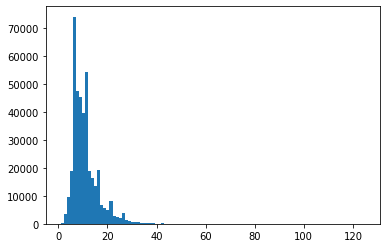

In [0]:
import matplotlib.pyplot as plt

plt.hist(df_train.question1.map(lambda x: len(str(x).split())).values, bins = 100)

In [0]:

stops = set(stopwords.words('english'))
outside_words=set()
from tqdm import tqdm
questions_cols = ['question1', 'question2']
for dataset in [df_train,df_test]:
  for index,row in (dataset.iterrows()):
   
    for question in questions_cols:
      
      q2n = [] 
      count_ = 0
   
      for word in text_to_word_list(row[question]):
        
        
       
        if word not in word2vec.vocab:
          outside_words.add(word)
          continue
          
        # limit the length to 50, this decreased the time to train an epoch 
        if count_ >= 50 :
          continue
        count_ +=1
        
        if word not in vocabulary:
          vocabulary[word] = len(inverse_vocabulary)
          q2n.append(len(inverse_vocabulary))
          inverse_vocabulary.append(word)
        else:
          q2n.append(vocabulary[word])
      
      
      dataset.at[index,question] = q2n
     
      
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary)+1, embedding_dim)
embeddings[0] = 0

# by using the code above, the first vector of embeddings are all 0.
embeddings[0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
for word, index in tqdm(vocabulary.items()):
  if word in word2vec.vocab:
    embeddings[index] = word2vec.word_vec(word)
    
del word2vec 
# calculate the max length 

max_seq_length = max(df_train.question1.map(lambda x:len(x)).max(),
                    df_train.question2.map(lambda x:len(x)).max(),
                    df_test.question1.map(lambda x:len(x)).max(),
                    df_test.question2.map(lambda x:len(x)).max())
print(max_seq_length)

100%|██████████| 58706/58706 [00:00<00:00, 242100.81it/s]


50


In [0]:

num_samples = len(df_train)
validation_size = (int)(num_samples * 0.2)
training_size = len(df_train) - validation_size 

X = df_train[questions_cols]
X_test = df_test[questions_cols]
Y = df_train['is_duplicate']

# train test split x and y into train and validation
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size = validation_size)

# Split to dicts
X_test = {'left':X_test.question1,'right':X_test.question2}
X_train = {'left':X_train.question1,'right':X_train.question2}
X_validation = {'left':X_validation.question1,'right':X_validation.question2}
#X_test = {'left':X_test.question1,'right':X_test.question2}

# fetch Ys
Y_train = Y_train.values
Y_test = Y_validation.values

# zero padding

for dataset, side in itertools.product([X_test, X_train,X_validation],['left','right']):
  dataset[side] = pad_sequences(dataset[side], maxlen = max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10, 8, 11]","[1, 2, 3, 4, 5, 4, 6, 7, 8, 9, 10]",0
1,1,3,4,"[1, 2, 3, 12, 13, 14, 15, 16]","[1, 17, 18, 19, 3, 20, 21, 22, 3, 13, 14, 15, ...",0
2,2,5,6,"[24, 25, 14, 26, 3, 27, 28, 29, 30, 31, 32, 33]","[24, 25, 29, 27, 34, 35, 5, 36, 37, 38]",0
3,3,7,8,"[39, 40, 14, 41, 42, 43, 24, 25, 14, 44, 45]","[46, 3, 47, 48, 49, 50, 49, 2, 51, 5]",0
4,4,9,10,"[52, 53, 54, 8, 55, 56, 57, 58, 59, 60, 61, 62]","[52, 63, 17, 64, 8, 58, 55]",0


In [0]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [0]:
import keras
!pip install tensorflow==1.14.0
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Lambda




n_hidden = 50
gradient_clipping_norm  = 1.25


batch_size = 256
n_epoch = 50

def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right),axis = 1, keepdims = True))

# a. input layer
left_input = Input(shape=(max_seq_length,), dtype="int32")
right_input = Input(shape=(max_seq_length,), dtype="int32")

# b. embedding layer
embedding_layer = Embedding(
    input_dim = len(embeddings), 
    
    output_dim = embedding_dim, # 
    weights= [embeddings], 
    input_length=max_seq_length,
    trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

#
shared_lstm = LSTM(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])


malstm = Model([left_input, right_input], [malstm_distance])
malstm.summary()







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      17612100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]     

In [0]:
optimizer = Adadelta(clipnorm = gradient_clipping_norm)

In [0]:

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])








In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)


malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation), callbacks=[early_stopping])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 323432 samples, validate on 80858 samples
Epoch 1/50
323432/323432 [==============================] - 378s 1ms/step - loss: 0.1925 - acc: 0.7074 - val_loss: 0.1782 - val_acc: 0.7316
Epoch 2/50
323432/323432 [==============================] - 376s 1ms/step - loss: 0.1737 - acc: 0.7427 - val_loss: 0.1720 - val_acc: 0.7498
Epoch 3/50
323432/323432 [==============================] - 370s 1ms/step - loss: 0.1682 - acc: 0.7560 - val_loss: 0.1687 - val_acc: 0.7586
Epoch 4/50
323432/323432 [==============================] - 370s 1ms/step - loss: 0.1645 - acc: 0.7645 - val_loss: 0.1652 - val_acc: 0.7634
Epoch 5/50
323432/323432 [==============================] - 371s 1ms/step - loss: 0.1615 - acc: 0.7711 - val_loss: 0.1630 - val_acc: 0.7718
Epoch 6/50
323432/323432 [==============================] - 374s 1ms/step - loss: 0.1590 - acc: 0.7765 - val_loss: 0.1611 - val_acc: 0.7726
Epoch 7/50
3234

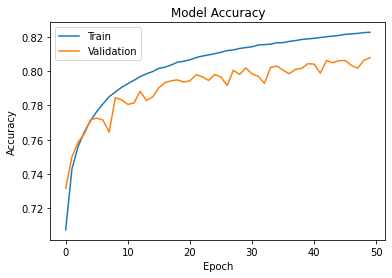

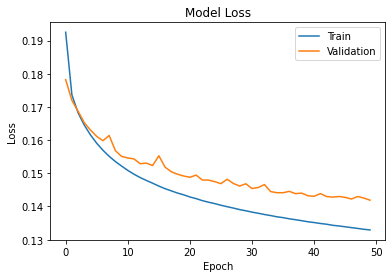

In [0]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()